# Training Gradient Boosting Models with CatBoost

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/events/2020_06_04_catboost_tutorial/catboost_features.ipynb)

## Libraries installation

In [1]:
# # For Google Colaboratory:
# !pip install catboost sklearn shap

# # For your machine:
# !pip install --user -U ipywidgets catboost sklearn shap
# !jupyter nbextension enable --py widgetsnbextension

In [2]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import catboost
print(catboost.__version__)

1.0.4


## Reading the data

In [3]:
from catboost.datasets import msrank_10k

# If you have "URLError: SSL: CERTIFICATE_VERIFY_FAILED" uncomment next two lines:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

(train_df, test_df) = msrank_10k()

In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2.0,1,3,3,0,0,3,1.0,1.0,0.000000,...,62,11089534,2,116,64034,13,3,0,0,0.0
1,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,54,11089534,2,124,64034,1,2,0,0,0.0
2,0.0,1,3,0,2,0,3,1.0,0.0,0.666667,...,45,3,1,124,3344,14,67,0,0,0.0
3,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,56,11089534,13,123,63933,1,3,0,0,0.0
4,1.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,64,5,7,256,49697,1,13,0,0,0.0


## Preparing the data

Label values extraction

In [5]:
y = train_df[0]
X = train_df.drop([0, 1], axis=1)

Ways to create Pool class. If you have a big dataset it is effective (in terms of time) to load data from file, instead of pandas Dataframe.

In [6]:
dataset_dir = './msrank_10k'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.csv'),
    index=False, sep=',', header=True
)

In [7]:
!head -2 msrank_10k/train.csv

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137
2.0,1,3,3,0,0,3,1.0,1.0,0.0,0.0,1.0,156,4,0,7,167,6.931275,22.076928,19.673353,22.255383,6.926551,3,3,0,0,6,1,1,0,0,2,1,1,0,0,2,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.019231,0.75,0.0,0.0,0.035928,0.00641,0.25,0.0,0.0,0.011976,0.00641,0.25,0.0,0.0,0.011976,0.00641,0.25,0.0,0.0,0.011976,0.0,0.0,0.0,0.0,0.0,6.931275,22.076928,0.0,0.0,13.853103,1.152128,5.99246,0.0,0.0,2.297197,3.078917,8.517343,0.0,0.0,6.156595,2.310425,7.358976,0.0,0.0,4.617701,0.694726,1.084169,0.0,0.0,2.78795,1,1,0,0,1,1.0,1.0,0.0,0.0,1.0,12.941469,20.59276,0.0,0.0,16.766961,-18.567

In [8]:
from catboost.utils import create_cd
feature_names = dict(map(lambda i: (i, 'Feature ' + str(i)), range(train_df.shape[1] - 2)))
    
create_cd(
    label=0,
    feature_names=feature_names,
    auxiliary_columns=[1],
    output_path=os.path.join(dataset_dir, 'train.cd')
)

In [9]:
!head msrank_10k/train.cd

0	Label	
1	Auxiliary	
2	Num	Feature 0
3	Num	Feature 1
4	Num	Feature 2
5	Num	Feature 3
6	Num	Feature 4
7	Num	Feature 5
8	Num	Feature 6
9	Num	Feature 7


In [10]:
from catboost import Pool

pool1 = Pool(data=X, label=y)

pool2 = Pool(
    data=os.path.join(dataset_dir, 'train.csv'), 
    delimiter=',', 
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True,
)

print('Dataset shape: {}\n'.format(pool1.shape))

Dataset shape: (10000, 136)



## Split your data into train and validation

In [11]:
from sklearn.model_selection import train_test_split

data = train_test_split(X, y, train_size=0.8, random_state=0)
X_train, X_validation, y_train, y_validation = data

train_pool = Pool(data=X_train, label=y_train)
validation_pool = Pool(data=X_validation, label=y_validation)

## Dataset Quantization

Features quantization. It is effective to quantize features single time before several trainings.

In [12]:
train_pool.quantize(
    border_count=254,
    # per_float_feature_quantization=['0:border_count=1024']
)

train_pool.save_quantization_borders('borders.tsv')

validation_pool.quantize(input_borders='borders.tsv')

In [13]:
from catboost.utils import quantize

pool2 = quantize(
    data_path=os.path.join(dataset_dir, 'train.csv'),
    delimiter=',',
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True,
)

## Training

In [14]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=5,
    learning_rate=0.1,
)
model.fit(train_pool, eval_set=validation_pool, verbose=False)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'RMSE'}


## Stdout of the training

In [15]:
model = CatBoostRegressor(
    iterations=15,
#     verbose=5,
)
model.fit(train_pool, eval_set=validation_pool);

Learning rate set to 0.5
0:	learn: 0.7708716	test: 0.7745190	best: 0.7745190 (0)	total: 10.3ms	remaining: 144ms
1:	learn: 0.7484358	test: 0.7586588	best: 0.7586588 (1)	total: 16.6ms	remaining: 108ms
2:	learn: 0.7382693	test: 0.7526478	best: 0.7526478 (2)	total: 22.6ms	remaining: 90.6ms
3:	learn: 0.7318817	test: 0.7485102	best: 0.7485102 (3)	total: 29.8ms	remaining: 81.8ms
4:	learn: 0.7249457	test: 0.7460277	best: 0.7460277 (4)	total: 35.2ms	remaining: 70.4ms
5:	learn: 0.7200842	test: 0.7431822	best: 0.7431822 (5)	total: 41.7ms	remaining: 62.5ms
6:	learn: 0.7153083	test: 0.7391365	best: 0.7391365 (6)	total: 47.2ms	remaining: 53.9ms
7:	learn: 0.7085841	test: 0.7380859	best: 0.7380859 (7)	total: 52.5ms	remaining: 45.9ms
8:	learn: 0.7041779	test: 0.7349667	best: 0.7349667 (8)	total: 57.8ms	remaining: 38.6ms
9:	learn: 0.7003200	test: 0.7331523	best: 0.7331523 (9)	total: 63.4ms	remaining: 31.7ms
10:	learn: 0.6980179	test: 0.7321064	best: 0.7321064 (10)	total: 68.7ms	remaining: 25ms
11:	learn

## Metrics calculation and graph plotting

In [16]:
model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.2,
    custom_metric=['MAE', 'R2']
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [17]:
model = CatBoostRegressor(
    iterations=100,
    eval_metric='MAE',
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 51


## Grid Search

In [19]:
pool = Pool(data=X_train, label=y_train)
model = CatBoostRegressor(iterations=10, eval_metric='MAE')
grid = {'learning_rate': [0.001, 0.01, 0.1], 'depth': [4, 5, 6]}
result = model.grid_search(grid, pool)

0:	learn: 0.6256421	test: 0.6431267	best: 0.6431267 (0)	total: 5.36ms	remaining: 48.2ms
1:	learn: 0.6256398	test: 0.6431126	best: 0.6431126 (1)	total: 30.9ms	remaining: 124ms
2:	learn: 0.6256466	test: 0.6431038	best: 0.6431038 (2)	total: 35.8ms	remaining: 83.6ms
3:	learn: 0.6256661	test: 0.6431049	best: 0.6431038 (2)	total: 41.9ms	remaining: 62.9ms
4:	learn: 0.6256627	test: 0.6430904	best: 0.6430904 (4)	total: 51.2ms	remaining: 51.2ms
5:	learn: 0.6256730	test: 0.6430896	best: 0.6430896 (5)	total: 58.4ms	remaining: 38.9ms
6:	learn: 0.6256826	test: 0.6430847	best: 0.6430847 (6)	total: 65.5ms	remaining: 28.1ms
7:	learn: 0.6256986	test: 0.6430885	best: 0.6430847 (6)	total: 79.1ms	remaining: 19.8ms
8:	learn: 0.6257280	test: 0.6431068	best: 0.6430847 (6)	total: 82.5ms	remaining: 9.17ms
9:	learn: 0.6257164	test: 0.6430883	best: 0.6430847 (6)	total: 85ms	remaining: 0us

bestTest = 0.6430847481
bestIteration = 6

0:	loss: 0.6430847	best: 0.6430847 (0)	total: 106ms	remaining: 851ms
0:	learn: 0.6

In [20]:
print('Best parameters: {}\n'.format(result['params']))

msg = 'Mean MAE value on validation set per each iteration:\n{}'
print(msg.format(np.round(result['cv_results']['test-MAE-mean'], 4)))

Best parameters: {'depth': 5, 'learning_rate': 0.1}

Mean MAE value on validation set per each iteration:
[0.6302 0.6305 0.6303 0.6294 0.6285 0.6269 0.627  0.626  0.6244 0.6232]


In [21]:
model.get_params()

{'iterations': 10,
 'loss_function': 'RMSE',
 'eval_metric': 'MAE',
 'depth': 5,
 'learning_rate': 0.1}

In [22]:
model.predict(validation_pool)

array([0.4917, 0.7217, 0.6462, ..., 0.7525, 0.4784, 0.7788])

In [23]:
model = CatBoostRegressor(iterations=100, eval_metric='MAE')
model.grid_search(grid, pool, plot=True, verbose=False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6256421	test: 0.6431267	best: 0.6431267 (0)	total: 4.74ms	remaining: 469ms
1:	learn: 0.6256398	test: 0.6431126	best: 0.6431126 (1)	total: 9.2ms	remaining: 451ms
2:	learn: 0.6256466	test: 0.6431038	best: 0.6431038 (2)	total: 13.6ms	remaining: 441ms
3:	learn: 0.6256661	test: 0.6431049	best: 0.6431038 (2)	total: 18.6ms	remaining: 445ms
4:	learn: 0.6256627	test: 0.6430904	best: 0.6430904 (4)	total: 22.5ms	remaining: 428ms
5:	learn: 0.6256730	test: 0.6430896	best: 0.6430896 (5)	total: 26.7ms	remaining: 419ms
6:	learn: 0.6256826	test: 0.6430847	best: 0.6430847 (6)	total: 30.1ms	remaining: 400ms
7:	learn: 0.6256986	test: 0.6430885	best: 0.6430847 (6)	total: 32.1ms	remaining: 369ms
8:	learn: 0.6257280	test: 0.6431068	best: 0.6430847 (6)	total: 35.1ms	remaining: 355ms
9:	learn: 0.6257164	test: 0.6430883	best: 0.6430847 (6)	total: 37.5ms	remaining: 338ms
10:	learn: 0.6257070	test: 0.6430680	best: 0.6430680 (10)	total: 39.9ms	remaining: 323ms
11:	learn: 0.6257142	test: 0.6430632	best:

More about parameter tuning you can find in [tutorial](https://github.com/catboost/catboost/blob/master/catboost/tutorials/hyperparameters_tuning/hyperparameters_tuning.ipynb).

## Feature importances

### Prediction values change

In [24]:
model.get_feature_importance(prettified=True).head()

,Feature Id,Importances
0,109,5.635690
1,135,5.635243
2,9,4.361557
3,12,3.151394
4,16,2.744412


### Loss function change

In [25]:
model.get_feature_importance(
    data=validation_pool, 
    type='LossFunctionChange',
    prettified=True
).head()

,Feature Id,Importances
0,135,0.009514
1,109,0.004881
2,15,0.001844
3,16,0.001190
4,136,0.001079


### Shap values

In [26]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.1)
model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);


shap_values = model.get_feature_importance(
    data=train_pool, 
    type='ShapValues'
)

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

(8000, 136)


In [29]:
import shap

shap.initjs()
shap.force_plot(
    expected_value,
    shap_values[1,:],
    feature_names=train_pool.get_feature_names()
)

In [30]:
shap.force_plot(
    expected_value,
    shap_values[7,:],
    feature_names=train_pool.get_feature_names()
)

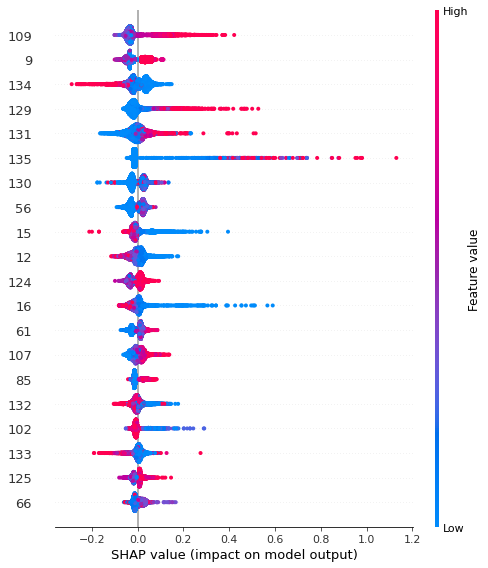

In [31]:
shap.summary_plot(shap_values, X_train)

More information about shap value usage you can find in [tutorial](https://github.com/catboost/catboost/blob/master/catboost/tutorials/model_analysis/shap_values_tutorial.ipynb).

## Tree Visualization

In [32]:
model = CatBoostRegressor(iterations=2, depth=1, boost_from_average=False)

features = [
    [1, 2, 3], 
    [4, 5, 6],
    [7, 8, 9]
]
labels = [1, 0, 1]

model.fit(features, labels, verbose=False);

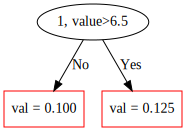

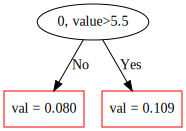

In [33]:
# This cell doesn't work without graphviz package
# You can install it by link https://graphviz.gitlab.io/download/
# Installation can take a lot of time. You can do it at home.

from IPython.display import display

display(model.plot_tree(0))
display(model.plot_tree(1))

In [34]:
x = [0, 7, 2]

raw_pred = model.predict([x])
print(raw_pred)

[0.205]


## Grow Policy

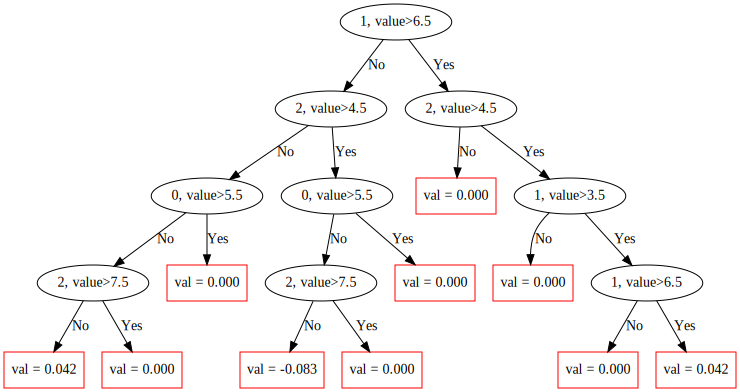

In [35]:
model = CatBoostRegressor(iterations=2, depth=4, grow_policy='Depthwise')
model.fit(features, labels, verbose=False);
display(model.plot_tree(0))

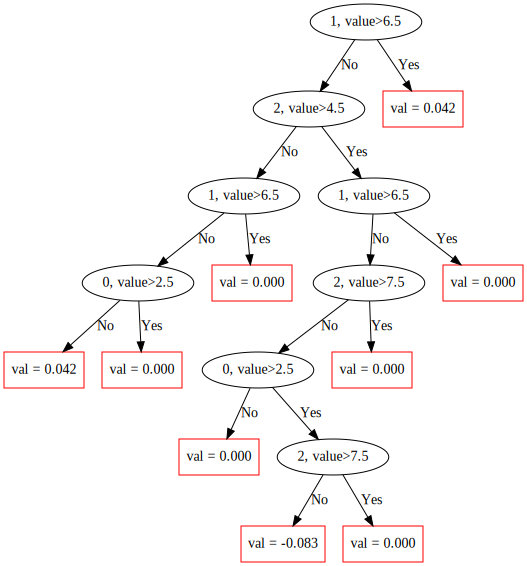

In [36]:
model = CatBoostRegressor(iterations=2, max_leaves=16, grow_policy='Lossguide')
model.fit(features, labels, verbose=False);
display(model.plot_tree(0))

## Snapshotting

In [37]:
# !rm 'catboost_info/snapshot.bkp'

model = CatBoostRegressor(
    iterations=200,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1
)

model.fit(train_pool, eval_set=validation_pool, verbose=10);

Learning rate set to 0.188388
0:	learn: 0.7890939	test: 0.7886477	best: 0.7886477 (0)	total: 15ms	remaining: 2.98s
10:	learn: 0.7262873	test: 0.7401040	best: 0.7401040 (10)	total: 77.8ms	remaining: 1.34s
20:	learn: 0.7060566	test: 0.7291165	best: 0.7291165 (20)	total: 133ms	remaining: 1.14s
30:	learn: 0.6888374	test: 0.7253688	best: 0.7253688 (30)	total: 188ms	remaining: 1.03s
40:	learn: 0.6771404	test: 0.7232882	best: 0.7231238 (38)	total: 249ms	remaining: 965ms
50:	learn: 0.6650135	test: 0.7209006	best: 0.7209006 (50)	total: 302ms	remaining: 883ms
60:	learn: 0.6522840	test: 0.7184939	best: 0.7182152 (59)	total: 357ms	remaining: 813ms
70:	learn: 0.6413634	test: 0.7177286	best: 0.7177286 (70)	total: 412ms	remaining: 748ms
80:	learn: 0.6339461	test: 0.7173161	best: 0.7168564 (77)	total: 490ms	remaining: 720ms
90:	learn: 0.6253891	test: 0.7152787	best: 0.7152787 (90)	total: 570ms	remaining: 683ms
100:	learn: 0.6139847	test: 0.7129890	best: 0.7129890 (100)	total: 643ms	remaining: 630ms
11

## Saving the model

In [38]:
model = CatBoostRegressor(iterations=10)
model.fit(train_pool, eval_set=validation_pool, verbose=False)
model.save_model('catboost_model.bin')
model.save_model('catboost_model.json', format='json')

In [39]:
model.load_model('catboost_model.bin')
print(model.get_params())
print(model.learning_rate_)

{'iterations': 10, 'loss_function': 'RMSE', 'verbose': 0}
0.5
